In [1]:
from pathlib import Path
from itertools import chain
from typing import NamedTuple

import shap
import pickle

import pandas as pd

import scipy
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


from thesis.plotting_utils import get_figsize, thesis_figure_style

In [2]:
DATA_DIR = Path("../data")
FIGURES_DIR = Path("../figures")

In [3]:
class ClassificationCondition(NamedTuple):
    veracity: str
    source: str
    strategy: str
    split: int

In [4]:
def load_shap_values(
    condition: ClassificationCondition, data_dir: Path = DATA_DIR
) -> tuple[shap.Explanation, pd.DataFrame]:
    results_dir = (
        data_dir
        / "classification"
        / "evaluation_results"
        / "bert"
        / f"{condition.veracity}_{condition.source}_{condition.strategy}_{condition.split}"
    )

    with open(results_dir / "shap_values.pkl", "rb") as f:
        shap_values = pickle.load(f)

    mapping = pd.read_csv(results_dir / "shap_value_id_mapping.csv", index_col=0)

    return shap_values, mapping


def get_testset_values(shap_values, mapping):
    test_set_idx = mapping.loc[lambda df: df.source != "amazon"]
    test_set_shap_values = shap_values[test_set_idx.index.to_list()]

    return test_set_shap_values

In [5]:
def concatenate_shap_explanations(exps: list[shap.Explanation]):
    if not all([exp.output_names == exps[0].output_names for exp in exps]):
        raise ValueError("Output names do not match")

    new_exp = shap.Explanation(
        values=np.concatenate([exp.values for exp in exps]),
        base_values=np.concatenate([exp.base_values for exp in exps]),
        data=tuple(chain.from_iterable([exp.data for exp in exps])),
        display_data=None,
        instance_names=None,
        feature_names=list(chain.from_iterable([exp.feature_names for exp in exps])),
        output_names=exps[0].output_names,
        output_indexes=None,
        lower_bounds=None,
        upper_bounds=None,
        error_std=None,
        main_effects=None,
        hierarchical_values=list(
            chain.from_iterable([exp.feature_names for exp in exps])
        ),
        clustering=np.concatenate([exp.clustering for exp in exps]),
    )
    return new_exp

## Base value distribution

0.010572702623903751


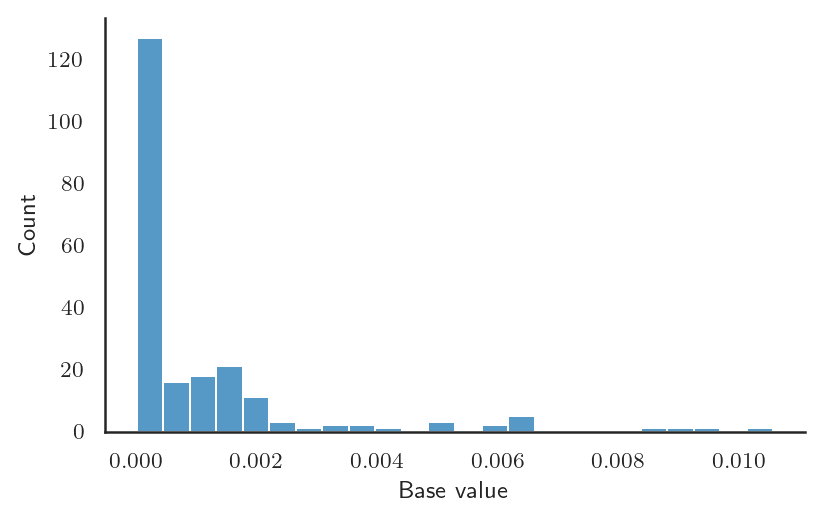

In [6]:
def plot_base_value_distribution():
    condition = ClassificationCondition("truthful", "openai", "minimal", 0)
    shap_values, mapping = load_shap_values(condition)
    test_set_shap_values = get_testset_values(shap_values, mapping)
    base_values = scipy.special.expit(test_set_shap_values[:, :, "llm"].base_values)

    print(max(base_values))

    with thesis_figure_style(sns_style_args={"style": "white"}):
        fig = plt.figure(figsize=get_figsize(fraction=0.8))
        ax = fig.gca()
        sns.histplot(base_values, ax=ax)
        sns.despine(ax=ax)
        ax.set_ylabel("Count")
        ax.set_xlabel("Base value")

        fig_path = FIGURES_DIR / "shap_base_value.pgf"
        fig.savefig(fig_path, backend="pgf")


plot_base_value_distribution()

## Mean shap values

In [7]:
def get_top_shap_values(shap_values, bottom=False, top_n=10):

    mean_values = shap_values.mean(0)
    sorted_idx = np.argsort(mean_values.values)

    if bottom:
        top_idx = sorted_idx[:top_n]
    else:
        top_idx = sorted_idx[-top_n:]

    values = mean_values.values[top_idx]
    tokens = mean_values.feature_names[top_idx]

    return tokens, values


def plot_mean_shap_values(condition: ClassificationCondition, bottom=False):
    shap_values, mapping = load_shap_values(condition)
    test_set_shap_values = get_testset_values(shap_values, mapping)

    top_tokens, top_values = get_top_shap_values(
        test_set_shap_values[:, :, "llm"], bottom=bottom
    )

    # return mean_values

    print(f"Values: {top_values}")

    with thesis_figure_style(sns_style_args={"style": "whitegrid"}):
        fig = plt.figure(figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8))
        ax = fig.gca()
        # shap.plots.bar(
        #     test_set_shap_values[:, :, "llm"].mean(0), max_display=10, show=False, ax=ax
        # )

        cmap = sns.color_palette()
        if bottom:
            color = cmap[0]
        else:
            color = cmap[1]

        sns.barplot(x=top_values, y=top_tokens, ax=ax, color=color)
        sns.despine(ax=ax, left=True, bottom=True)

        if bottom:
            ax.set_xlim(-4.8, 0)
            type_ = "bottom"
        else:
            ax.set_xlim(0, 4.8)
            type_ = "top"

        fig_path = FIGURES_DIR / f"shap_{type_}10_mean.pgf"
        fig.savefig(fig_path, backend="pgf")

        plt.show()

Values: [1.96055274 1.97697186 2.09532968 2.14373847 2.28185749 2.38728611
 2.65413293 2.71450435 3.71844708 4.50819285]


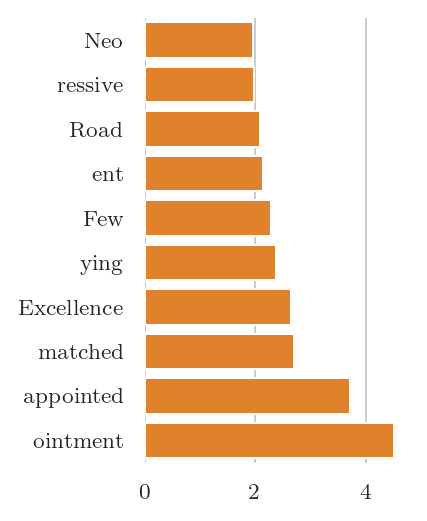

In [8]:
plot_mean_shap_values(ClassificationCondition("truthful", "openai", "minimal", 1))

Values: [-1.10941788 -0.91143588 -0.77159917 -0.7698305  -0.67197986 -0.61837014
 -0.60119764 -0.46923895 -0.38125062 -0.34847014]


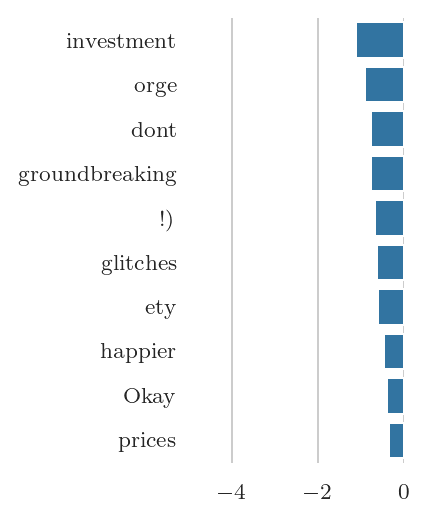

In [9]:
plot_mean_shap_values(
    ClassificationCondition("truthful", "openai", "minimal", 1), bottom=True
)

In [10]:
shap_values, mapping = load_shap_values(
    ClassificationCondition("truthful", "openai", "minimal", 1)
)
test_set_shap_values = get_testset_values(shap_values, mapping)
raw_values = test_set_shap_values[:, :, "llm"].mean(0).values

print(f"Mean: {raw_values.mean()}")
print(f"Std.: {raw_values.std()}")

Mean: 0.08494495979759326
Std.: 0.3022312588066455


## Single examples

In [11]:
def load_predictions(condition: ClassificationCondition) -> pd.DataFrame:
    predictions = pd.read_csv(
        DATA_DIR
        / "classification"
        / "evaluation_results"
        / "bert"
        / f"{condition.veracity}_{condition.source}_{condition.strategy}_{condition.split}"
        / "evaluation_results.csv"
    )

    return predictions


def load_example_data(condition: ClassificationCondition):
    review_info = pd.read_csv(
        DATA_DIR / "human" / "review_data_preprocessed.csv", index_col="id"
    )
    shap_values, mapping = load_shap_values(condition)
    predictions = (
        load_predictions(condition)
        .set_index(["review_id", "label", "source", "strategy"])
        .predictions
    )

    mapping = (
        mapping.join(review_info["length_category"], on="review_id")
        .assign(label=lambda df: df.label.map({0: "human", 1: "llm"}))
        .join(predictions, on=["review_id", "label", "source", "strategy"])
    )

    return shap_values, mapping


def plot_example(
    condition: ClassificationCondition, true_label, predicted_label, length_category=3
):
    shap_values, mapping = load_example_data(condition)

    reviews = mapping.loc[
        lambda df: (df.label == true_label)
        & (df.predictions == predicted_label)
        & (df.source != "amazon")
        & (df.length_category == length_category)
    ]

    if len(reviews) == 0:
        raise Exception(
            "For the given condition, true and predicted labels no reviews exists. Try a different condition."
        )

    shap_id = reviews.sample(1, random_state=42).iloc[0].name
    print(reviews.sample(1, random_state=42).iloc[0].review_id)

    shap.plots.text(shap_values[shap_id, :, "llm"], cmax=3.1)

### True positive

In [12]:
plot_example(ClassificationCondition("truthful", "openai", "minimal", 1), "llm", "llm")

431


### True negative

In [13]:
plot_example(
    ClassificationCondition("truthful", "openai", "minimal", 1), "human", "human"
)

431


### False negative

In [14]:
plot_example(
    ClassificationCondition("truthful", "openai", "minimal", 1),
    "llm",
    "human",
    length_category=1,
)

865


### False positive

In [16]:
plot_example(
    ClassificationCondition("truthful", "openai", "minimal", 2),
    "human",
    "llm",
    length_category=2,
)

982


### Color bar

In [17]:
def print_shap_colorbar():
    with thesis_figure_style(rc_args={"figure.constrained_layout.use": False}):
        fig = plt.figure(figsize=get_figsize(aspectratio=0.1, fraction=0.8))
        ax = fig.gca()
        cb = fig.colorbar(
            ScalarMappable(
                norm=Normalize(-3.1, 3.1), cmap=shap.plots.colors.red_white_blue
            ),
            ax=ax,
            orientation="horizontal",
            fraction=1,
            drawedges=False,
        )
        cb.outline.set_visible(False)
        ax.axis("off")

        fig_path = FIGURES_DIR / f"shap_colorbar.pgf"
        fig.savefig(fig_path, backend="pgf")


print_shap_colorbar()